In [55]:
import cv2
import numpy as np
import tensorflow as tf
import random
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [8]:
model = tf.saved_model.load("ASDF")

In [5]:
img_path = "Data/img_align_celeba/img_align_celeba"
#model = tf.keras.models.load_model("./FL_gen16_qat_adam_lr0005_batsz32_dset3")
jpg_files = [file for file in os.listdir(img_path) if file.endswith('.jpg')]
random.shuffle(jpg_files)
current_index = 0

In [6]:
#skip
model.compile(
    optimizer="adam",
    loss='mse'
)

In [88]:
def quadratic_func(x, a, p, q):
    return a * (x-p)**2 + q




In [121]:
current_index = 1442

imgShape (1, 256, 256, 3)
heatmaps shape:  (1, 64, 64, 68)
heatmaps shapeTR:  (68, 64, 64)


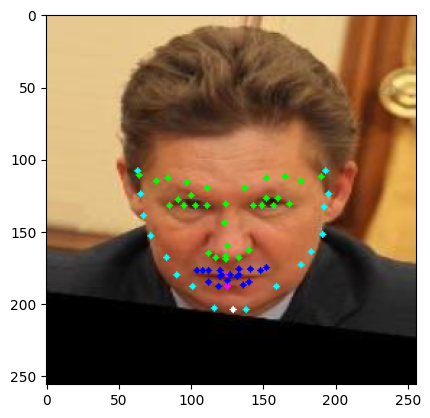

In [122]:
image_path = os.path.join(img_path, jpg_files[current_index])
faceArr = []
image = cv2.imread(image_path)
image = cv2.resize(image, (256, 256))
face_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faceImg_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
faceImg_std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
face_image = ((np.array(face_image, dtype=np.float32) / 255.0) - faceImg_mean) / faceImg_std

faceArr.append(face_image)
faceArr = np.array(faceArr, dtype=np.float32)
print("imgShape", faceArr.shape)
    
#heatmaps = model.predict(faceArr)
heatmaps = model(faceArr).numpy()
print("heatmaps shape: ", heatmaps.shape)
heatmaps = np.transpose(heatmaps[0], (2, 0, 1))
print("heatmaps shapeTR: ", heatmaps.shape)

marks = []
for heatmap in heatmaps:
    h_height, h_width = heatmap.shape
    flatMap = heatmap.flatten()
    indices = np.argpartition(flatMap, -2)[-2:]
    indices = indices[np.argsort(-flatMap[indices])]

    [y1, y2], [x1, x2] = np.unravel_index(indices, heatmap.shape)
    x = (x1 + (x2 - x1)/4) / h_width * 256
    y = (y1 + (y2 - y1)/4) / h_height * 256
    marks.append((int(x), int(y)))

n = 0

chin_arr = []
chin_arrX = []
chin_arrY = []
up_lip = 0
down_lip = 0

for mark in marks:
    #print(mark)
    x, y = mark[0], mark[1]
    if n < 17:
        chin_arr.append((x, y))
        chin_arrX.append(x)
        chin_arrY.append(256 - y)
        if n == 8:
            cv2.circle(image, (x, y), 2, (255, 255, 255), -1)
        else:
            cv2.circle(image, (x, y), 2, (255, 255, 0), -1)
    elif n > 47:
        if n == 51 or n == 57:
            cv2.circle(image, (x, y), 2, (255, 0, 255), -1)
        else:
            cv2.circle(image, (x, y), 2, (255, 0, 0), -1)
    else:
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

    if n == 51:
        up_lip = y
    if n == 57:
        down_lip = y
    n += 1
mouth_h = down_lip - up_lip

plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))


턱의 기울기 :0.019342197796900454
입 높이 : 8


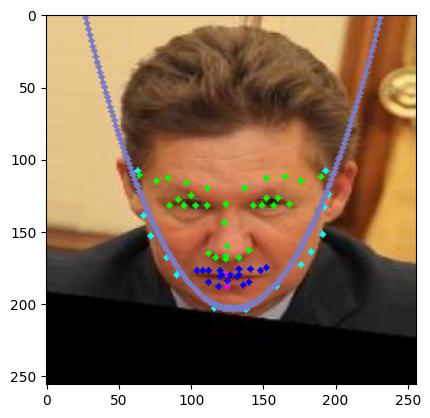

In [123]:
popt, popc = curve_fit(quadratic_func, chin_arrX, chin_arrY, method="lm")

print("턱의 기울기 :" + str(popt[0]))
print("입 높이 : " + str(mouth_h))

xp = np.arange(0, 256)
yp = 256 - popt[0] * ((xp - chin_arr[8][0]) ** 2) - 256 + chin_arr[8][1]

for i in range(256):
    cv2.circle(image, (int(xp[i]), int(yp[i])), 2, (200, 123, 123), -1)

plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))